# Setting

In [1]:
import torch
import math
import matplotlib.pyplot as plt
from easydict import EasyDict as edict
from utils import utils, verification, verification_inverse
from Reconstruction import direct_attack, transfer_attack

### Desciption of the local FRS and the inverse model. (Architecture / Loss / Train_set)

- Local FRS:     ResNet-50 / ArcFace            / MS1M-v3
- Inverse model: NbNet     / Pixel and Percetual / MS1M-v3

In [2]:
device = torch.device('cuda:0')
local = utils.local_FRS().eval().to(device)
local_inverse = utils.local_inverse().eval().to(device)

###### For checking the performance of our local and inverse models. You can use below code. ######
# dataset_lfw = verification.load_bin('./utils/dataset/lfw.bin', (112, 112))
# local_th = verification.test(dataset_lfw, local, 64, device, 10)
# with torch.no_grad():
#     verification_inverse.test_inverse(dataset_lfw, local, local_th, local_inverse, 64, device, 1)

### Description of open-source Target FRS (Architecture / Loss / Train_set)

- t1: ResNet-100         / CosFace     / Glint360K
- t2: Vision Transformer / CosFace     / MS1M-v3
- t3: ResNet-50          / ArcFace     / WebFace12M
- t4: SFNet-20           / SphereFace2 / VGGFace2
- t5: Inception-ResNet   / Triplet     / CASIA-WebFace

### Attack Scenario
- Direct_Type1 attack  : Face reconstruction a image against a target FRS.
- Direct_Type2 attack  : Face reconstruction a image against a target FRS, and test with a different image of same identity.
- Transfer_Type1 attack: Face reconstruction a image against a target FRS, and test against a different target FRS.
- Transfer_Type2 attack: Face reconstruction a image against a target FRS, and test against a different target FRS with a different image of same identity.

In [3]:
# Modify here. Target FRS of direct attack.

_target_FRS = 't1' # t1 ~ t5 and AWS
direct_type = 2 # 1 or 2
target_id = 2167 # Available samples: 310, 760, 2167

In [4]:
vit = False
imgsize = 112
if _target_FRS !='AWS':
    target_FRS = utils.target_FRS(_target_FRS, device)
    target_FRS.eval().to(device)
    
    if _target_FRS == 't2':
        vit = True
    elif _target_FRS == 't5':
        imgsize = 160
    else:
        vit = False
        imgsize = 112

    dataset_lfw = verification.load_bin('./utils/dataset/lfw.bin', (imgsize, imgsize))
    th = verification.test(dataset_lfw, target_FRS, 64, device, 10, vit)
    th_angle = math.acos((th-2)/(-2))*180/math.pi
else:
    target_FRS='AWS'
    th_angle = 80

loading bin 0
loading bin 1000
loading bin 2000
loading bin 3000
loading bin 4000
loading bin 5000
loading bin 6000
loading bin 7000
loading bin 8000
loading bin 9000
loading bin 10000
loading bin 11000
torch.Size([12000, 3, 112, 112])

testing verification..
(12000, 512)
infer time 37.35309099999998
Accuracy: 0.998


# Direct Attack

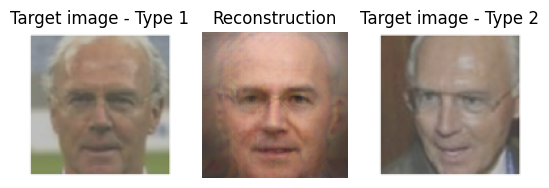

Angle distance: 59.339271596688235
Threshold: 72.54239687627792


In [5]:
args = edict()
args.device = device
args.local = local
args.local_inverse = local_inverse
ofs = utils.ofs_load()
ofs = ofs.to(device)
args.ofs = ofs
args.bb_FRS = target_FRS
args.bb_th = th_angle
args.bb_imgsize = imgsize
args.direct_type = direct_type
args.target_id = target_id
args.vit = vit

recon, cos = direct_attack(args)

#plot
targetimg1 = utils.targetimg_type1(imgsize=args.bb_imgsize, target_id=args.target_id)

plt.subplot(1, direct_type+1, 1)
plt.axis('off')
plt.imshow(targetimg1)
plt.title('Target image - Type 1')

plt.subplot(1, direct_type+1, 2)
plt.axis('off')
plt.imshow(recon)
plt.title('Reconstruction')

if direct_type==2:
    targetimg2 = utils.targetimg_type2(imgsize=args.bb_imgsize, target_id=args.target_id)
    plt.subplot(1, 3, 3)
    plt.axis('off')
    plt.imshow(targetimg2)
    plt.title('Target image - Type 2')
    
plt.show()
if target_FRS!='AWS':
    print('Angle distance:', math.acos(cos)*180/math.pi)
    print('Threshold:', args.bb_th)
else:
    print('Confidence score:', cos)
    print('Threshold:', args.bb_th)

# Transfer Attack

In [6]:
# Adds a target FRS of transfer attack.

_target_FRS_transfer = 't2' # t1 ~ t5 and AWS
transfer_type = 1 # 1 or 2
target_id = 2167 # Available samples: 310, 760, 2167

In [7]:
transfer_vit = False
imgsize_transfer = 112

if _target_FRS_transfer !='AWS':
    target_FRS_transfer = utils.target_FRS(target_FRS = _target_FRS_transfer).eval().to(device)

    if _target_FRS_transfer == 't2':
        transfer_vit = True
    elif _target_FRS_transfer == 't5':
        imgsize = 160
        dataset_lfw = verification.load_bin('./utils/dataset/lfw.bin', (imgsize, imgsize))
    else:
        transfer_vit = False
        imgsize_transfer = 112

    th_transfer = verification.test(dataset_lfw, target_FRS_transfer, 64, device, 10, transfer_vit)
    th_transfer_angle = math.acos((th_transfer-2)/(-2))*180/math.pi
    direct_type = None
else:
    target_FRS_transfer='AWS'
    th_transfer_angle = 80

self.device_id 0

testing verification..
(12000, 512)
infer time 72.81009499999999
Accuracy: 0.998


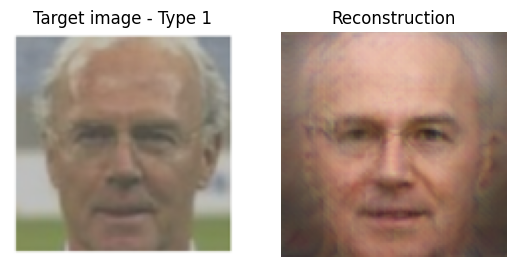

Angle distance: 53.18594265694968
Threshold: 77.29096700560457


In [8]:
args = edict()
args.device = device
args.local = local
args.local_inverse = local_inverse
args.ofs = utils.ofs_load()
args.bb_FRS = target_FRS
args.bb_th = th_angle
args.bb_imgsize = imgsize
args.direct_type = direct_type
args.transfer_FRS = target_FRS_transfer
args.transfer_th = th_transfer_angle
args.transfer_imgsize = imgsize_transfer
args.transfer_type = transfer_type
args.target_id = target_id
args.vit = vit
args.transfer_vit = transfer_vit

recon, cos = transfer_attack(args)

#plot
targetimg1 = utils.targetimg_type1(imgsize=args.bb_imgsize, target_id=args.target_id)

plt.subplot(1, transfer_type+1, 1)
plt.axis('off')
plt.imshow(targetimg1)
plt.title('Target image - Type 1')

plt.subplot(1, transfer_type+1, 2)
plt.axis('off')
plt.imshow(recon)
plt.title('Reconstruction')

if transfer_type==2:
    targetimg2 = utils.targetimg_type2(imgsize=args.bb_imgsize, target_id=args.target_id)
    plt.subplot(1, 3, 3)
    plt.axis('off')
    plt.imshow(targetimg2)
    plt.title('Target image - Type 2')
    
plt.show()
if target_FRS_transfer!='AWS':
    print('Angle distance:', math.acos(cos)*180/math.pi)
    print('Threshold:', args.transfer_th)
else:
    print('Confidence score:', cos)
    print('Threshold:', args.transfer_th)

# GenOFS
Instead of our pre-generated OFS, you can generate your own OFS.
You should prepare a dataset for extracting face templates to find orthogonal templates.

In [ ]:
from Reconstruction import GenOFS

device = torch.device('cuda:0')
dataset = 'your dataset'  
ofs_num = 99  # Modify the number of orthogonal face images that you want to generate.
savepath='./param/ofs.pt'

GenOFS(device, dataset, ofs_num, savepath) # OFS is saved in the form of tensors.

In [ ]:
# Checking almost-orthogonality of OFS.
ofs = torch.load(savepath)
model = utils.local_FRS(device=device) # Modify here if you check the alomost-orthogonality in the different FRS.

orthogonal_check(ofs, model)